In [51]:
import os
import shutil

# Define the base directory name
base_dir = 'Meat_Freshness.v1i.multiclass2_reorganized_split'

# Check if the directory exists
if os.path.exists(base_dir) and os.path.isdir(base_dir):
    print(f"Directory '{base_dir}' found. Deleting it and its contents...")
    try:
        shutil.rmtree(base_dir)
        print(f"Directory '{base_dir}' and its contents successfully deleted.")
    except OSError as e:
        print(f"Error: Could not delete directory '{base_dir}'. Reason: {e}")
else:
    print(f"Directory '{base_dir}' not found. Proceeding to the next Colab cell.")

Directory 'Meat_Freshness.v1i.multiclass2_reorganized_split' found. Deleting it and its contents...
Directory 'Meat_Freshness.v1i.multiclass2_reorganized_split' and its contents successfully deleted.


In [52]:

# --- Sistem File dan Path ---
import os
import shutil
from shutil import copyfile
import zipfile
import pathlib
from pathlib import Path

# --- Utilitas Umum ---
import random
from random import sample
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- Data Manipulasi ---
import numpy as np
import pandas as pd

# --- Visualisasi ---
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns
from tqdm.notebook import tqdm as tq

# --- Pemrosesan Gambar ---
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# --- Pembelajaran Mesin & Deep Learning ---
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, img_to_array, load_img
)
from tensorflow.keras.layers import (
    InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D,
    Dense, Flatten, Dropout, BatchNormalization
);
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
)

# --- Evaluasi Model ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
!unzip '/content/drive/MyDrive/PI/Meat_Freshness.v1i.multiclass2_reorganized_split.zip'


Streaming output truncated to the last 5000 lines.
  inflating: Meat_Freshness.v1i.multiclass2_reorganized_split/train/NOT_MEAT/20085.jpg  
  inflating: Meat_Freshness.v1i.multiclass2_reorganized_split/train/NOT_MEAT/20087.jpg  
  inflating: Meat_Freshness.v1i.multiclass2_reorganized_split/train/NOT_MEAT/20088.jpg  
  inflating: Meat_Freshness.v1i.multiclass2_reorganized_split/train/NOT_MEAT/20089.jpg  
  inflating: Meat_Freshness.v1i.multiclass2_reorganized_split/train/NOT_MEAT/20090.jpg  
  inflating: Meat_Freshness.v1i.multiclass2_reorganized_split/train/NOT_MEAT/20091.jpg  
  inflating: Meat_Freshness.v1i.multiclass2_reorganized_split/train/NOT_MEAT/20092.jpg  
  inflating: Meat_Freshness.v1i.multiclass2_reorganized_split/train/NOT_MEAT/20093.jpg  
  inflating: Meat_Freshness.v1i.multiclass2_reorganized_split/train/NOT_MEAT/20095.jpg  
  inflating: Meat_Freshness.v1i.multiclass2_reorganized_split/train/NOT_MEAT/20096.jpg  
  inflating: Meat_Freshness.v1i.multiclass2_reorganized_spl

In [ ]:
base_dir = '/content/Meat_Freshness.v1i.multiclass2_reorganized_split'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
IMG_SHAPE = IMG_SIZE + (3,)  
train_dir = os.path.join(base_dir + '/train')
valid_dir = os.path.join(base_dir + '/valid')
test_dir = os.path.join(base_dir + '/test')


✅ Distribusi gambar per kelas:
- FRESH: 1758 gambar
- SPOILED: 1832 gambar
- NOT_MEAT: 2400 gambar


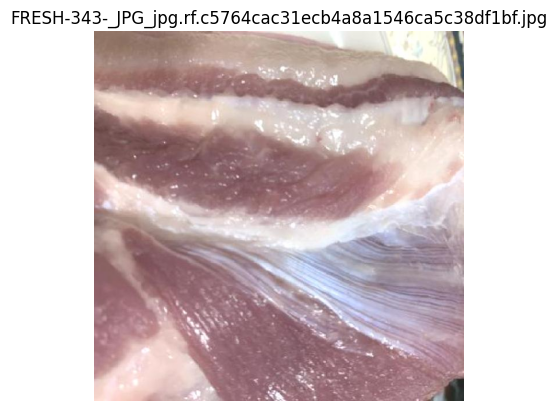

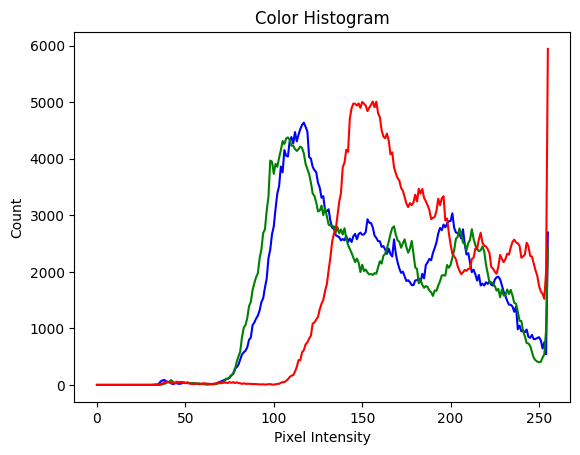

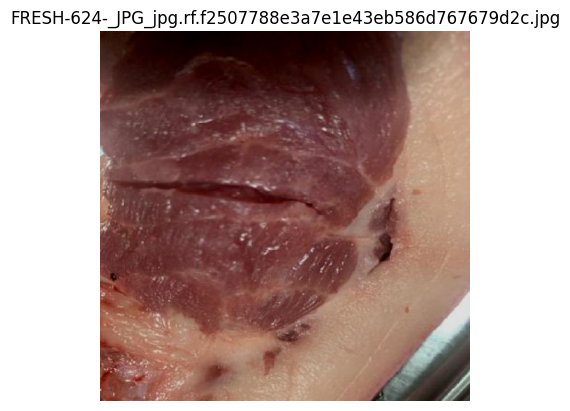

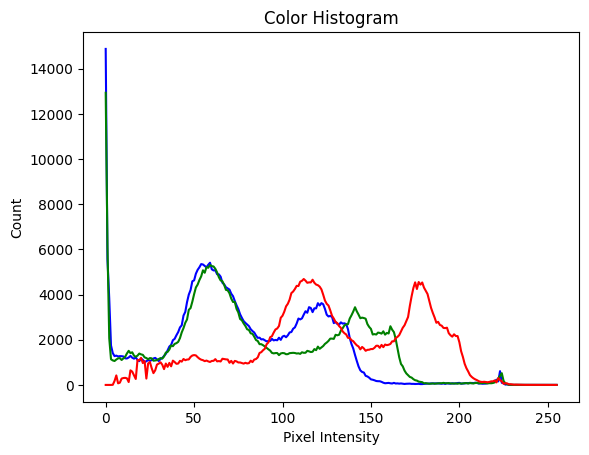

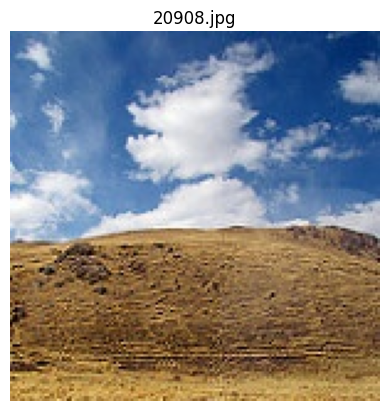

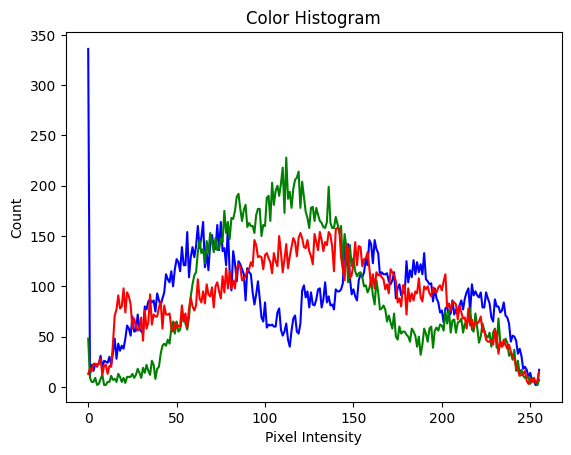

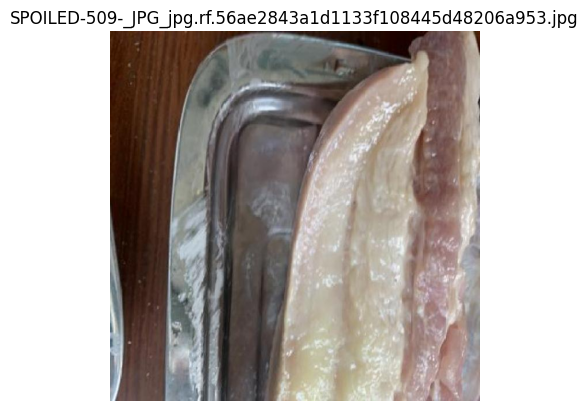

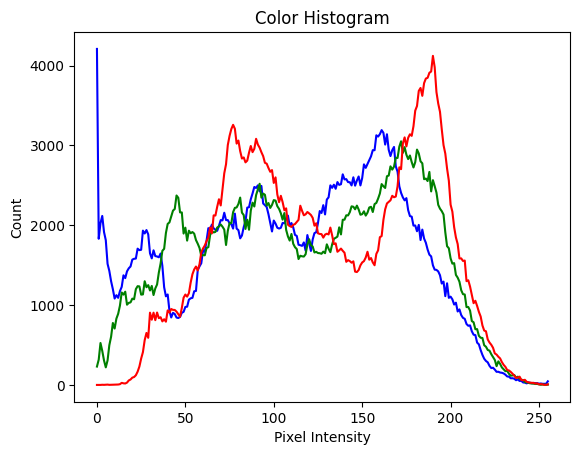

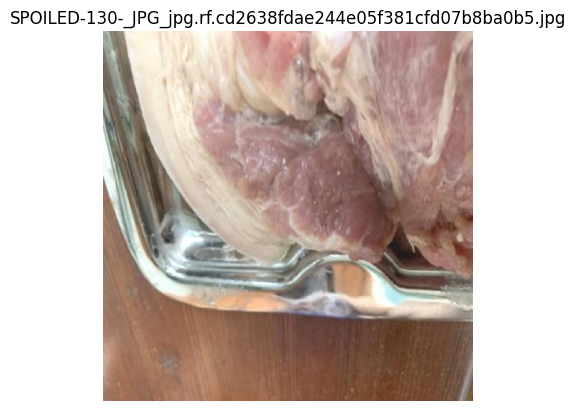

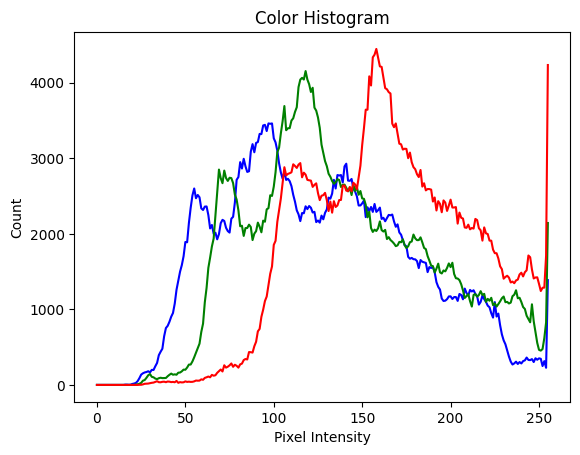

In [56]:
import os
import cv2
import matplotlib.pyplot as plt
import random
from collections import Counter


folder_path = os.path.join(base_dir, "train")

# Ambil semua gambar dari FRESH, SPOILED, dan NOT_MEAT
image_files = []
for label in ['FRESH', 'SPOILED', 'NOT_MEAT']:
    subfolder = os.path.join(folder_path, label)
    if not os.path.exists(subfolder):
        print(f"🚫 Folder tidak ditemukan: {subfolder}")
        continue
    for fname in os.listdir(subfolder):
        if fname.lower().strip().endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(subfolder, fname)
            image_files.append(full_path)

# Tampilkan jumlah gambar per kelas
label_counts = Counter([os.path.basename(os.path.dirname(p)) for p in image_files])
print("✅ Distribusi gambar per kelas:")
for label, count in label_counts.items():
    print(f"- {label}: {count} gambar")

# Acak gambar agar representatif dari semua kelas
random.shuffle(image_files)

# Tampilkan 5 gambar dan histogram warnanya
for img_path in image_files[:5]:
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ Gagal membaca gambar: {img_path}")
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Tampilkan gambar
    plt.imshow(img_rgb)
    plt.title(os.path.basename(img_path))
    plt.axis("off")
    plt.show()

    # Tampilkan histogram warna
    for i, col in enumerate(['b', 'g', 'r']):
        histr = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(histr, color=col)
    plt.title("Color Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Count")
    plt.show()


In [ ]:


# Augmentasi hanya untuk data training (disesuaikan agar realistis untuk daging)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,         
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2], 
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    shuffle=False
)


Found 4193 validated image filenames belonging to 3 classes.
Found 898 validated image filenames belonging to 3 classes.
Found 899 validated image filenames belonging to 3 classes.


In [62]:
print(train_generator.class_indices)


{'FRESH': 0, 'NOT_MEAT': 1, 'SPOILED': 2}


In [ ]:
from tensorflow.keras.layers import Input
tf.keras.backend.clear_session()

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
base_model.trainable = False

model = Sequential([
    Input(shape=IMG_SHAPE),
    base_model,
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax') 
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,023,011 (11.53 MB)

 Trainable params: 765,027 (2.92 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [64]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8420 - loss: 0.3753
Epoch 1: val_loss improved from inf to 0.18625, saving model to best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 533ms/step - accuracy: 0.8425 - loss: 0.3742 - val_accuracy: 0.9365 - val_loss: 0.1863 - learning_rate: 5.0000e-04
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9536 - loss: 0.1110
Epoch 2: val_loss improved from 0.18625 to 0.06190, saving model to best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 62s 472ms/step - accuracy: 0.9536 - loss: 0.1110 - val_accuracy: 0.9744 - val_loss: 0.0619 - learning_rate: 5.0000e-04
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9695 - loss: 0.0730
Epoch 3: val_loss improved from 0.06190 to 0.04362, saving model to best_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 61s 464ms/step - accuracy: 0.9695 - loss: 0.0730 - val_accuracy: 0.9800 - val_loss: 0.0436 - learning_rate: 5.0000e-04
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0

In [65]:
from tensorflow.keras.models import load_model

model = load_model("best_model.keras")
model.save("best_model.h5")

In [66]:
# Evaluasi pada data train
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
print(f"Akurasi Training Set   : {train_acc * 100:.2f}%")
print(f"Loss Training Set      : {train_loss:.4f}")

# Evaluasi pada data test
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Akurasi Testing Set    : {test_acc * 100:.2f}%")
print(f"Loss Testing Set       : {test_loss:.4f}")

Akurasi Training Set   : 99.86%
Loss Training Set      : 0.0052
Akurasi Testing Set    : 99.56%
Loss Testing Set       : 0.0227


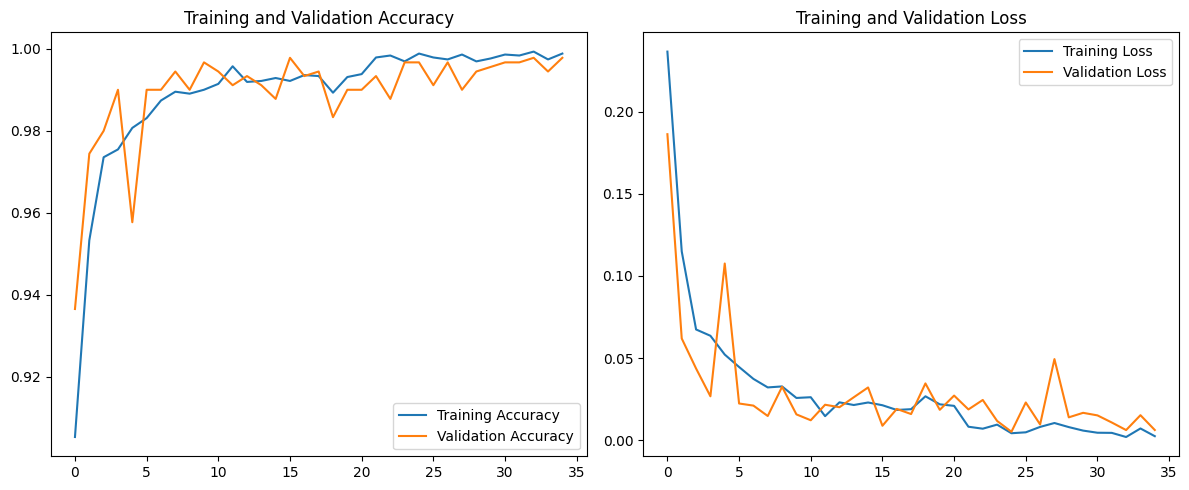

In [69]:
# Visualisasi akurasi dan loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step


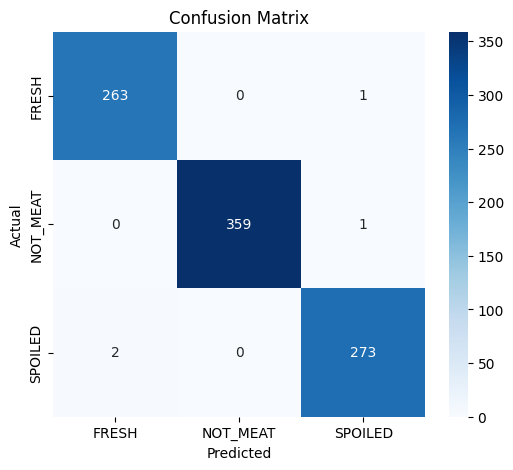

In [70]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Prediksi label
y_true = df_test['label'].values
y_pred_prob = model.predict(test_generator)
y_pred = y_pred_prob.argmax(axis=1)

# Konversi label dari string ke angka
label_map = {label: i for i, label in enumerate(test_generator.class_indices)}
y_true_encoded = [label_map[label] for label in y_true]

# Confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


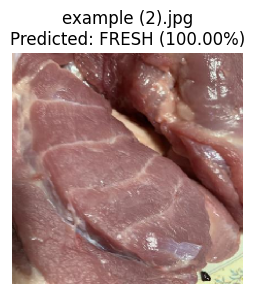

example (2).jpg: FRESH (100.00%)


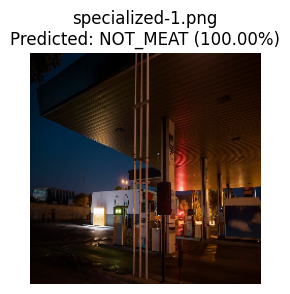

specialized-1.png: NOT_MEAT (100.00%)


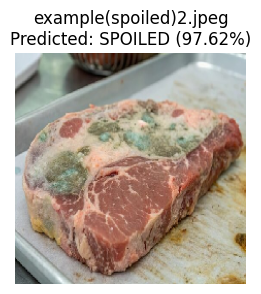

example(spoiled)2.jpeg: SPOILED (97.62%)


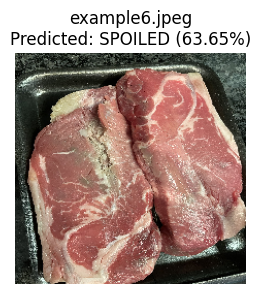

example6.jpeg: SPOILED (63.65%)


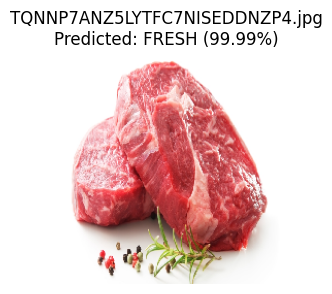

TQNNP7ANZ5LYTFC7NISEDDNZP4.jpg: FRESH (99.99%)


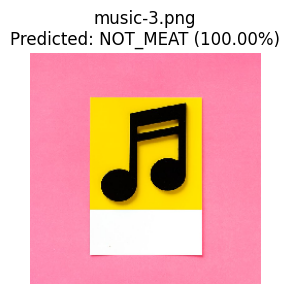

music-3.png: NOT_MEAT (100.00%)


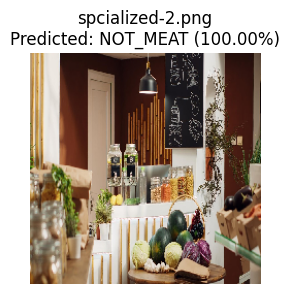

spcialized-2.png: NOT_MEAT (100.00%)


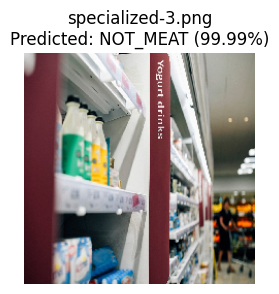

specialized-3.png: NOT_MEAT (99.99%)


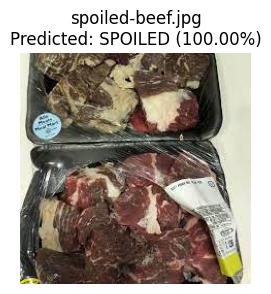

spoiled-beef.jpg: SPOILED (100.00%)


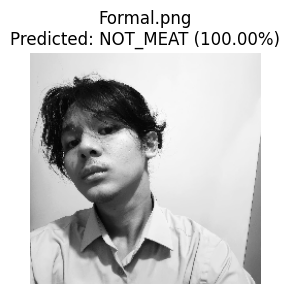

Formal.png: NOT_MEAT (100.00%)


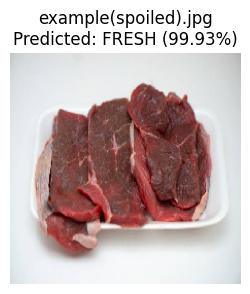

example(spoiled).jpg: FRESH (99.93%)


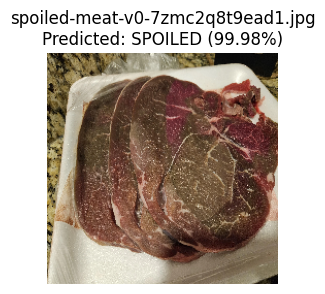

spoiled-meat-v0-7zmc2q8t9ead1.jpg: SPOILED (99.98%)


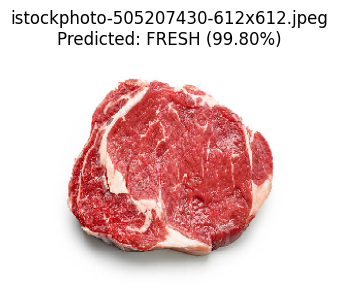

istockphoto-505207430-612x612.jpeg: FRESH (99.80%)


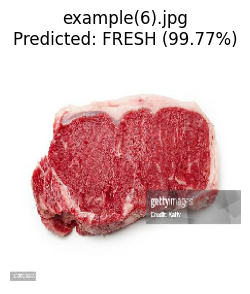

example(6).jpg: FRESH (99.77%)


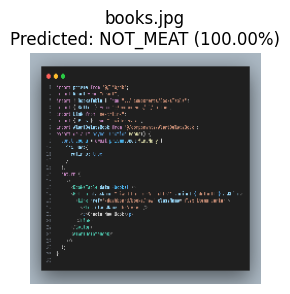

books.jpg: NOT_MEAT (100.00%)


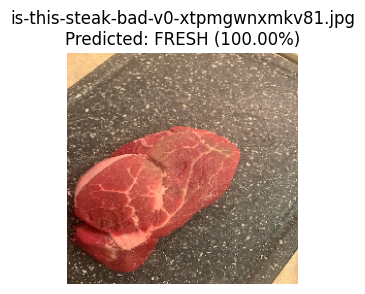

is-this-steak-bad-v0-xtpmgwnxmkv81.jpg: FRESH (100.00%)


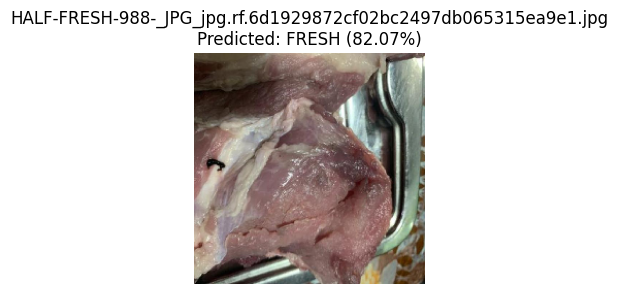

HALF-FRESH-988-_JPG_jpg.rf.6d1929872cf02bc2497db065315ea9e1.jpg: FRESH (82.07%)


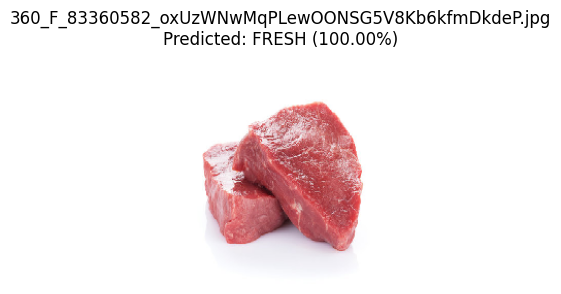

360_F_83360582_oxUzWNwMqPLewOONSG5V8Kb6kfmDkdeP.jpg: FRESH (100.00%)


In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_images_in_folder(folder_path, model, class_indices):
    inverse_class_indices = {v: k for k, v in class_indices.items()}
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.png')):
            img_path = os.path.join(folder_path, filename)
            img = image.load_img(img_path, target_size=IMG_SIZE)
            img_array = image.img_to_array(img) / 255.0
            img_batch = np.expand_dims(img_array, axis=0)
            predictions = model.predict(img_batch, verbose=0)[0]
            pred_index = np.argmax(predictions)
            pred_class = inverse_class_indices[pred_index]
            confidence = predictions[pred_index]
            plt.figure(figsize=(3, 3))
            plt.imshow((img_array * 255).astype("uint8"))
            plt.axis('off')
            plt.title(f"{filename}\nPredicted: {pred_class} ({confidence*100:.2f}%)")
            plt.show()
            print(f"{filename}: {pred_class} ({confidence*100:.2f}%)")

predict_images_in_folder('/content/example', model, {'FRESH': 0, 'NOT_MEAT': 1, 'SPOILED': 2})


In [ ]:
base_model.trainable = True

for layer in base_model.layers[:100]: 
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n📋 Model summary setelah fine-tuning setup:\n")

model.summary()


📋 Model summary setelah fine-tuning setup:



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,023,011 (11.53 MB)

 Trainable params: 765,027 (2.92 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [75]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

fine_tune_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint("fine_tuned_model.keras", monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]


In [76]:
fine_tune_history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=fine_tune_callbacks
)


Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9994 - loss: 0.0050
Epoch 1: val_loss improved from inf to 0.01092, saving model to fine_tuned_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 81s 522ms/step - accuracy: 0.9994 - loss: 0.0050 - val_accuracy: 0.9967 - val_loss: 0.0109 - learning_rate: 1.0000e-05
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9975 - loss: 0.0077
Epoch 2: val_loss improved from 0.01092 to 0.01043, saving model to fine_tuned_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 61s 461ms/step - accuracy: 0.9975 - loss: 0.0076 - val_accuracy: 0.9967 - val_loss: 0.0104 - learning_rate: 1.0000e-05
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9984 - loss: 0.0040
Epoch 3: val_loss improved from 0.01043 to 0.00854, saving model to fine_tuned_model.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 89s 517ms/step - accuracy: 0.9984 - loss: 0.0041 - val_accuracy: 0.9967 - val_loss: 0.0085 - learning_rate: 1.0000e-05
Epoch 4/20
132/132 ━━━━

In [77]:
print("📊 Evaluasi setelah fine-tuning:")
final_train_loss, final_train_acc = model.evaluate(train_generator)
final_val_loss, final_val_acc = model.evaluate(val_generator)
final_test_loss, final_test_acc = model.evaluate(test_generator)

print(f"📌 Final Train Accuracy: {final_train_acc*100:.2f}%")
print(f"📌 Final Val Accuracy  : {final_val_acc*100:.2f}%")
print(f"📌 Final Test Accuracy : {final_test_acc*100:.2f}%")


📊 Evaluasi setelah fine-tuning:
132/132 ━━━━━━━━━━━━━━━━━━━━ 63s 478ms/step - accuracy: 0.9998 - loss: 0.0011
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9963 - loss: 0.0064
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9948 - loss: 0.0203
📌 Final Train Accuracy: 99.98%
📌 Final Val Accuracy  : 99.67%
📌 Final Test Accuracy : 99.56%


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step


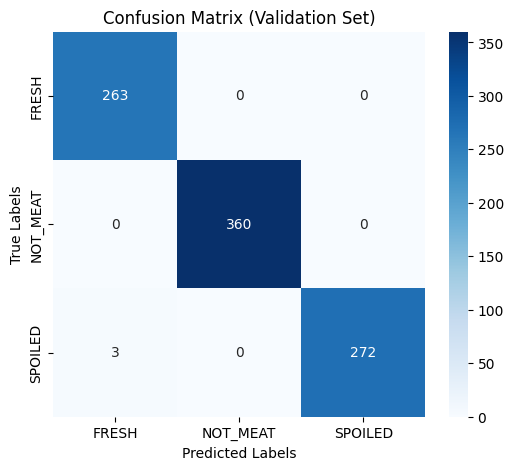

              precision    recall  f1-score   support

       FRESH       0.99      1.00      0.99       263
    NOT_MEAT       1.00      1.00      1.00       360
     SPOILED       1.00      0.99      0.99       275

    accuracy                           1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898



In [78]:

# Dapatkan prediksi dari model (probabilitas)
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Label asli
y_true = val_generator.classes

# Mapping indeks ke label
class_labels = list(val_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_labels))


In [82]:
# Jika sebelumnya kamu punya `history`, bisa digabungkan
def plot_training_history(history, title=''):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend()
    plt.title(f'Training and Validation Accuracy {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend()
    plt.title(f'Training and Validation Loss {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()


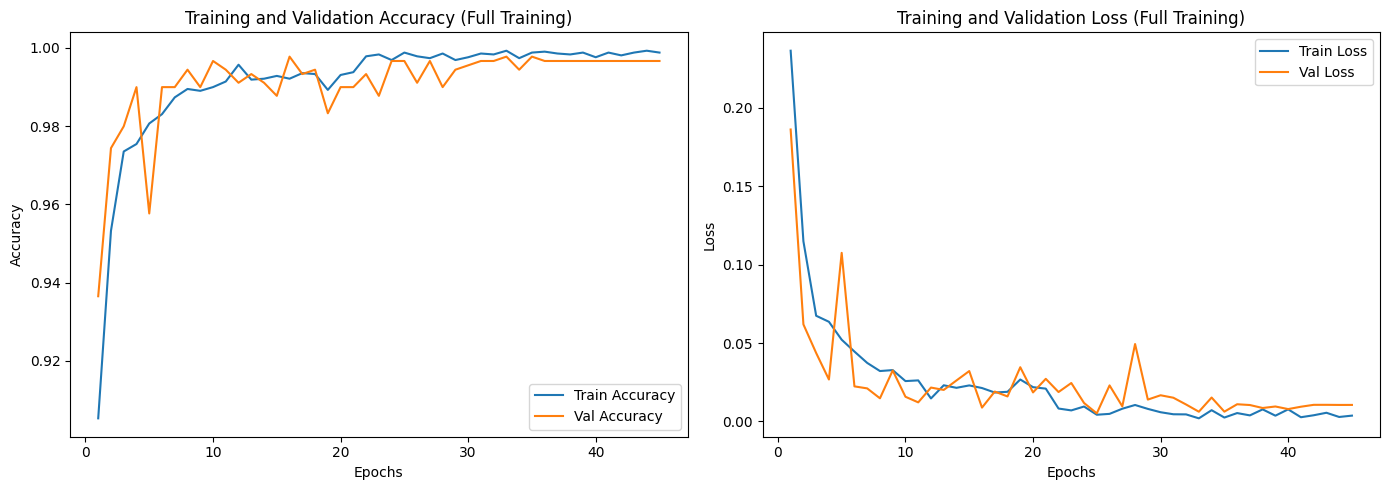

In [83]:
# Merge history sebelum dan sesudah fine-tuning
def merge_history(h1, h2):
    history = {}
    for key in h1.history.keys():
        history[key] = h1.history[key] + h2.history[key]
    return history

# Misal sebelumnya ada `initial_history`
full_history = merge_history(history, fine_tune_history)
plot_training_history(type('obj', (object,), {'history': full_history})(), title='(Full Training)')


In [85]:
fine_tuned_model = load_model("fine_tuned_model.keras")

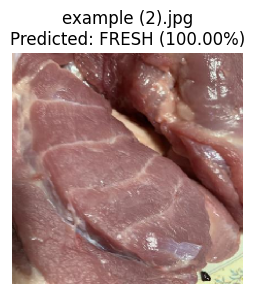

example (2).jpg: FRESH (100.00%)


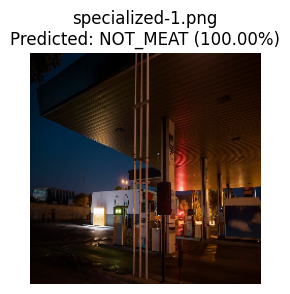

specialized-1.png: NOT_MEAT (100.00%)


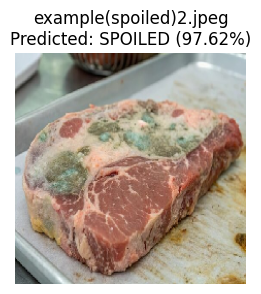

example(spoiled)2.jpeg: SPOILED (97.62%)


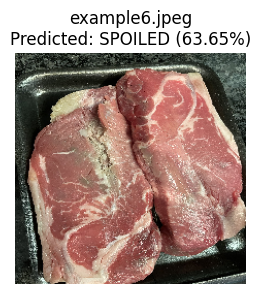

example6.jpeg: SPOILED (63.65%)


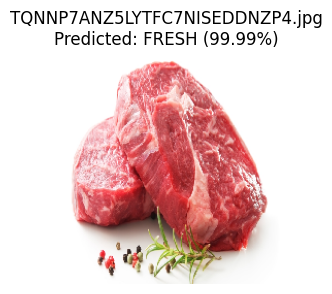

TQNNP7ANZ5LYTFC7NISEDDNZP4.jpg: FRESH (99.99%)


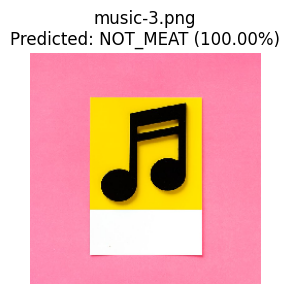

music-3.png: NOT_MEAT (100.00%)


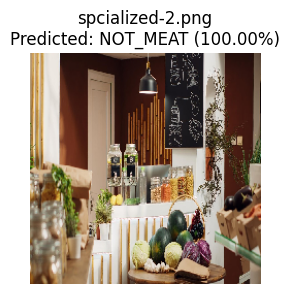

spcialized-2.png: NOT_MEAT (100.00%)


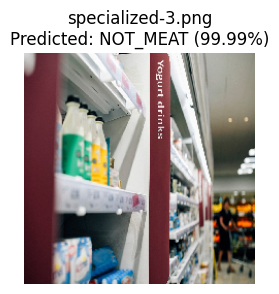

specialized-3.png: NOT_MEAT (99.99%)


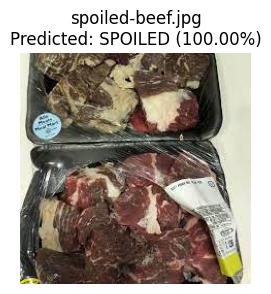

spoiled-beef.jpg: SPOILED (100.00%)


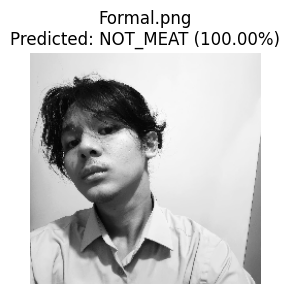

Formal.png: NOT_MEAT (100.00%)


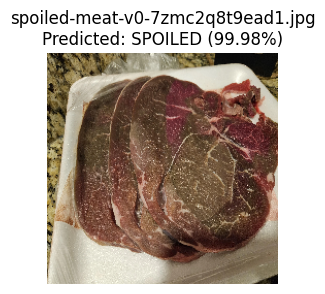

spoiled-meat-v0-7zmc2q8t9ead1.jpg: SPOILED (99.98%)


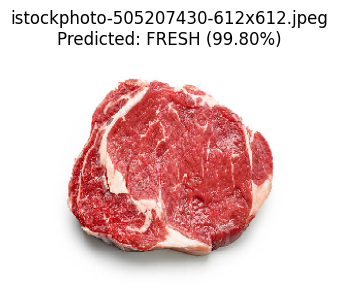

istockphoto-505207430-612x612.jpeg: FRESH (99.80%)


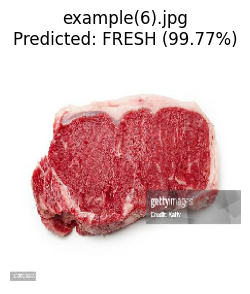

example(6).jpg: FRESH (99.77%)


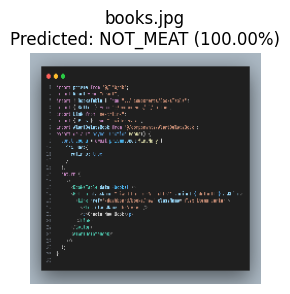

books.jpg: NOT_MEAT (100.00%)


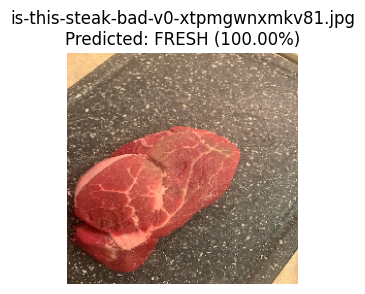

is-this-steak-bad-v0-xtpmgwnxmkv81.jpg: FRESH (100.00%)


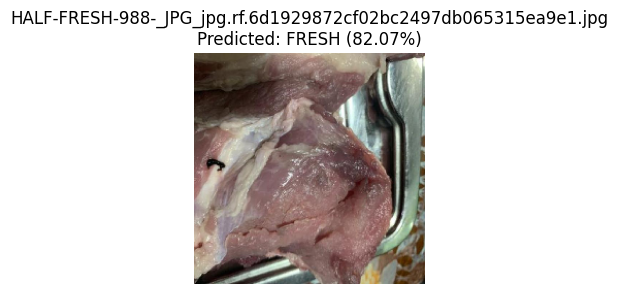

HALF-FRESH-988-_JPG_jpg.rf.6d1929872cf02bc2497db065315ea9e1.jpg: FRESH (82.07%)


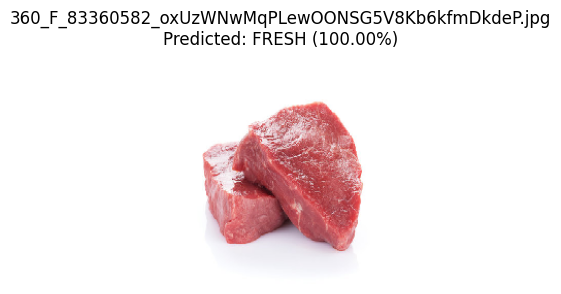

360_F_83360582_oxUzWNwMqPLewOONSG5V8Kb6kfmDkdeP.jpg: FRESH (100.00%)


In [92]:
# Contoh pemanggilan
predict_images_in_folder('/content/example', fine_tuned_model, train_generator.class_indices)


In [90]:
fine_tuned_model.save("final_model.h5")

In [93]:
from google.colab import files
files.download('final_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>